In [1]:
import os
import matplotlib.pyplot as plt
from preprocessing import *
# %pip install fasttext-wheel
from lstm import *
from crf import create_bio_tags

ROOT_DIR = os.path.dirname(os.path.abspath(""))

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
ft = load_fasttext()

In [41]:
model = LSTM(
	model_path=os.path.join(ROOT_DIR, "models", "lstm_0_1.pt"),
	device=device,
	hyperparams={
		"input_dim": 617,
		"hidden_dim": 300,
		"num_layers": 2,
		"output_dim": 9,
		"seq_len": 10,
		"epochs": 1,
		"batch_size": 32,
		"learning_rate": 1e-3,
		"num_workers": 12,
		"dataset_type": "overlapping",
	},
	ft=ft,
	verbose=True,
)

Preparing training set...
Training model...
Epoch [1/1], Batch [5705/5705], Loss: 0.0005954817170277238


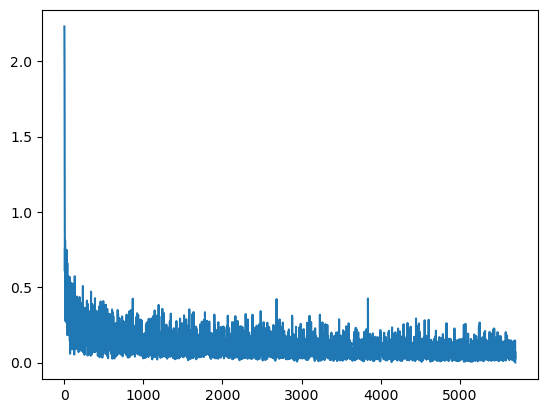

In [42]:
losses = model.train(
	train_tokens_path=os.path.join(ROOT_DIR, "data", "training_data_tokens.json"),
	train_lemmas_path=os.path.join(ROOT_DIR, "data", "training_data_lemmas.json"),
	train_pos_path=os.path.join(ROOT_DIR, "data", "training_data_pos.json"),
	train_labels_path=os.path.join(ROOT_DIR, "data", "training_data_bio.json"),
	frac=1.0
)
plt.plot(losses)

In [43]:
model.save()

In [50]:
loss, accuracy = model.evaluate(
	test_tokens_path=os.path.join(ROOT_DIR, "data", "test_data_tokens.json"),
	test_lemmas_path=os.path.join(ROOT_DIR, "data", "test_data_lemmas.json"),
	test_pos_path=os.path.join(ROOT_DIR, "data", "test_data_pos.json"),
	test_labels_path=os.path.join(ROOT_DIR, "data", "test_data_bio.json"),
	frac=1.0
)

Preparing test set...


100%|██████████| 1479/1479 [00:09<00:00, 153.03it/s]

Test Loss: 0.1205, Test Accuracy: 0.9697


In [51]:
pred = model.predict(
	["vejiga", "de", "correcta", "capacidad", "250", "cc", "de", "contraste", "de", "paredes", "trabeculadas", "y", "con", "diverticulos", "el", "mayor", "de", "ellos", "en", "cara", "posterolateral", "izquierda", "sin", "observarse", "defectos", "de", "replecion"],
	["vejiga", "de", "correcto", "capacidad", "250", "cc", "de", "contraste", "de", "pared", "trabeculada", "y", "con", "diverticulo", "el", "mayor", "de", "\u00e9l", "en", "cara", "posterolateral", "izquierdo", "sin", "observar \u00e9l", "defecto", "de", "replecion"],
	["NOUN", "ADP", "ADJ", "NOUN", "NUM", "NUM", "ADP", "NOUN", "ADP", "NOUN", "ADJ", "CCONJ", "ADP", "NOUN", "DET", "ADJ", "ADP", "PRON", "ADP", "NOUN", "ADJ", "ADJ", "ADP", "VERB", "PRON", "NOUN", "ADP", "PROPN"],
)

---

In [40]:
train_data_tokens = load_tokens(os.path.join(ROOT_DIR, "data", "training_data_tokens.json"))
with open(os.path.join(ROOT_DIR, "data", "training_data.json"), "r") as f:
	train_data = json.load(f)
train_data_bio = create_bio_tags(train_data, train_data_tokens)
with open(os.path.join(ROOT_DIR, "data", "training_data_bio.json"), "w") as f:
	json.dump(train_data_bio, f)

In [11]:
with open(os.path.join(ROOT_DIR, "data", "training_data_lemmas.json"), "r") as f:
	train_data_lemmas = json.load(f)
with open(os.path.join(ROOT_DIR, "data", "training_data_pos.json"), "r") as f:
	train_data_pos = json.load(f)

In [34]:
training_set = OverlappingWindowDataset(
	train_data_tokens,
	train_data_lemmas,
	train_data_pos,
	train_data_bio,
	ft,
	seq_len=10,
	padding_value=0)

In [35]:
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=12)

In [36]:
# Hyperparameters
word_embedding_dim = 617 # 300 word, 300 lemma, 17 pos
hidden_dim = 300
num_classes = 9
num_layers=2
# Instantiate the model
model = NegationDetectionModel(word_embedding_dim, hidden_dim, num_layers, num_classes)
model.to(device)

NegationDetectionModel(
  (bilstm): LSTM(617, 300, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=600, out_features=9, bias=True)
)

In [37]:
def count_parameters(model):
	return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

4375809

In [17]:
# Training function
def train(model, dataloader, criterion, optimizer, device, epochs=10):
	losses = []
	for epoch in range(epochs):
		for sequences, targets in tqdm(dataloader):
			# Forward pass
			sequences = sequences.to(device)
			targets = targets.to(device)

			outputs = model(sequences)
			outputs = outputs.view(-1, outputs.shape[-1])
			targets = targets.view(-1).long()
			# Compute loss
			loss = criterion(outputs, targets)
			
			# Backward pass and optimization
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			losses.append(loss.item())
			
		print(f'Epoch {epoch+1}, Loss: {loss.item()}')
	return losses

100%|██████████| 5705/5705 [01:18<00:00, 72.99it/s]

Epoch 1, Loss: 0.0014026316348463297


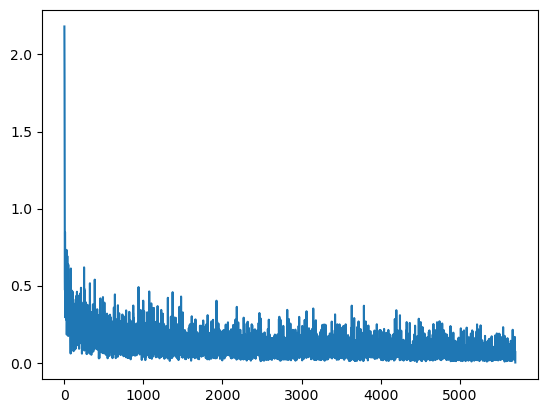

In [38]:
from torch import nn, optim

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = train(model, train_loader, criterion, optimizer, device, epochs=1)
plt.plot(losses)

In [39]:
# Test the model
def test(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for sequences, targets in tqdm(dataloader):
            # Forward pass
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            outputs = model(sequences)
            outputs = outputs.view(-1, outputs.shape[-1])
            targets = targets.view(-1).long()
            
            # Compute loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    
    average_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')
    
    return average_loss, accuracy

test(model, train_loader, criterion, device)

100%|██████████| 5705/5705 [00:36<00:00, 154.98it/s]

Test Loss: 0.0539, Test Accuracy: 0.9837


(0.053875244882751146, 0.9836940979241655)